In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#link to the challenge https://www.kaggle.com/competitions/rpl-attacks-detection/data

In [34]:
dataset = pd.read_csv("data/train_data.csv")
final_test = pd.read_csv("data/test_data.csv")

In [109]:
dataset["packet_duration"].skew()

3.211376503054166

In [289]:
dataset["second_frame"].value_counts()

second_frame
SF_493258    16
SF_104321    16
SF_804991    15
SF_535643    15
SF_880699    15
             ..
SF_836725     1
SF_982148     1
SF_982688     1
SF_998511     1
SF_167078     1
Name: count, Length: 2044, dtype: int64

In [295]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# tiny transformer that removes 'SF_' and converts to int
class SFRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X[0, :].astype('string').replace(r'^SF_', '', regex=True)
        X = pd.to_numeric(X, errors='coerce').fillna(0).astype(np.int32)
        return X.values.reshape(-1, 1)

In [296]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PowerTransformer

# col_killer = ColumnTransformer(
#     transformers=[  # transform A, B
#         ('drop_cols', 'drop', ['src_ip', 'dest_ip', 'packet_id']),  
#         ('hotaf', OneHotEncoder(), ['protocol', 'info']),
#         ('POWAAAAAAAAAA', PowerTransformer(method="yeo-johnson"), ['packet_duration']),
#         ('scalethatshit', StandardScaler(), ['length', 'packet_duration']),
#     ],
#     remainder='passthrough'  # keep anything else not mentioned
# )

def clean_sf_columns(X):
    """Clean SF_ prefix from columns and convert to numeric"""
    if hasattr(X, 'iloc'):  # pandas DataFrame/Series
        result = X.astype(str).str.replace(r'^SF_', '', regex=True)
    
    return pd.to_numeric(result, errors='coerce').fillna(0).astype(np.int32)

sf_cleaner = FunctionTransformer(
    clean_sf_columns,
    feature_names_out='one-to-one'
)

col_killer = ColumnTransformer( 
    transformers=[
        ('Hot', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False,
            dtype=np.int64   # ✅ ensure numeric (not string)
        ), ['protocol', 'info']),
        ('POWAAAA', PowerTransformer(method="yeo-johnson"), ['packet_duration']),
        ('fuck you SF', SFRemover(), ['second_frame']),
        ('ScaleDatShit', StandardScaler(), ['length', 'packet_duration', 'second_frame']),
    ],
    remainder='drop'  # ✅ drop anything unhandled to avoid objects
)


preprocessing = make_pipeline(
    col_killer,
)

better_dataset = preprocessing.fit_transform(dataset)

cols = preprocessing.named_steps['columntransformer'].get_feature_names_out()

better_dataset = pd.DataFrame(better_dataset, columns=cols)
# better_dataset["second_frame"] = dataset["second_frame"].astype('string').replace(r"^SF_","",regex=True).astype(np.int64)

better_dataset.head(10)

InvalidIndexError: (0, slice(None, None, None))

In [259]:
better_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11663 entries, 0 to 11662
Data columns (total 13 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Hot__protocol_ICMPv6                                           11663 non-null  float64
 1   Hot__protocol_IEEE 802.15.4                                    11663 non-null  float64
 2   Hot__protocol_UDP                                              11663 non-null  float64
 3   Hot__info_Ack                                                  11663 non-null  float64
 4   Hot__info_RPL Control (DODAG Information Object)               11663 non-null  float64
 5   Hot__info_RPL Control (DODAG Information Solicitation)         11663 non-null  float64
 6   Hot__info_RPL Control (Destination Advertisement Object)       11663 non-null  float64
 7   Hot__info_Source port: ultraseek-http  Destination port: r

In [161]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(dataset, test_size=0.2, random_state=67, stratify=dataset["protocol"])
better_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11663 entries, 0 to 11662
Data columns (total 12 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Hot__protocol_ICMPv6                                           11663 non-null  float64
 1   Hot__protocol_IEEE 802.15.4                                    11663 non-null  float64
 2   Hot__protocol_UDP                                              11663 non-null  float64
 3   Hot__info_Ack                                                  11663 non-null  float64
 4   Hot__info_RPL Control (DODAG Information Object)               11663 non-null  float64
 5   Hot__info_RPL Control (DODAG Information Solicitation)         11663 non-null  float64
 6   Hot__info_RPL Control (Destination Advertisement Object)       11663 non-null  float64
 7   Hot__info_Source port: ultraseek-http  Destination port: r

In [262]:
X = better_dataset
y = dataset["target"]


In [60]:
train["info"].value_counts()

info
RPL Control (Destination Advertisement Object)         6637
RPL Control (DODAG Information Object)                 1540
Source port: ultraseek-http  Destination port: rrac    1040
Ack                                                      70
RPL Control (DODAG Information Solicitation)             35
Unknown (17)                                              8
Name: count, dtype: int64

In [182]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11663 entries, 0 to 11662
Data columns (total 12 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Hot__protocol_ICMPv6                                           11663 non-null  float64
 1   Hot__protocol_IEEE 802.15.4                                    11663 non-null  float64
 2   Hot__protocol_UDP                                              11663 non-null  float64
 3   Hot__info_Ack                                                  11663 non-null  float64
 4   Hot__info_RPL Control (DODAG Information Object)               11663 non-null  float64
 5   Hot__info_RPL Control (DODAG Information Solicitation)         11663 non-null  float64
 6   Hot__info_RPL Control (Destination Advertisement Object)       11663 non-null  float64
 7   Hot__info_Source port: ultraseek-http  Destination port: r

In [178]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


#Logistic Regression
#Decision Tree
#RandomForest
#SVC

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=67),
    "Decision Tree": DecisionTreeClassifier(random_state=67),
    "Gradient Boosting": GradientBoostingClassifier(random_state=67),
}

scoring = "roc_auc"

results = {}
for name, model in models.items():
    probs = cross_val_predict(model, X, y, cv=3, n_jobs=-1, method='predict_proba')[:, 1]
    preds = (probs >= 0.5).astype(int)

    auc = roc_auc_score(y, probs)
    rec = recall_score(y, preds)
    
    results[name] = (auc, rec)
    print(f"{name}: roc_auc={auc:.4f}, recall={rec:.4f}")

# print(results)
# best_model_name = max(results, key=results.get)
# print("\nBest Model:", best_model_name)
# print("Best CV Score:", results[best_model_name])


TypeError: 'module' object is not callable

In [264]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,       # number of trees
    learning_rate=0.1,      # shrinkage rate
    max_depth=5,            # max depth per tree
    subsample=0.8,          # fraction of rows per tree
    colsample_bytree=0.8,   # fraction of columns per tree
    random_state=67,
    eval_metric='auc'       # evaluation metric for training
)


probs = cross_val_predict(model, X, y, cv=3, n_jobs=-1, method='predict_proba')[:, 1]
preds = (probs >= 0.5).astype(int)

auc = roc_auc_score(y, probs)
rec = recall_score(y, preds)

print(f"CHIKOUR JABLI roc_auc={auc:.4f}, recall={rec:.4f}")


CHIKOUR JABLI roc_auc=0.8607, recall=0.5212


In [261]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, recall_score

# Define base model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5],
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define custom scorers
roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
recall_scorer = make_scorer(recall_score)

# Grid search for best ROC-AUC
grid_auc = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=roc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_auc.fit(X, y)
print("🏆 Best model by ROC-AUC:")
print(f"ROC-AUC = {grid_auc.best_score_:.4f}")
print("Best Params:", grid_auc.best_params_)

# # Grid search for best Recall
# grid_recall = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring=recall_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )
# grid_recall.fit(X, y)
# print("\n🏆 Best model by Recall:")
# print(f"Recall = {grid_recall.best_score_:.4f}")
# print("Best Params:", grid_recall.best_params_)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


ValueError: 
All the 2916 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2916 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'string'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1784, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 701, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1254, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 1768, in __init__
    self._init(
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 1832, in _init
    it.reraise()
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 617, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 598, in _handle_exception
    return fn()
           ^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 685, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 1632, in next
    input_data(**self.kwargs)
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 665, in input_data
    new, feature_names, feature_types = _proxy_transform(
                                        ^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 1685, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 662, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:second_frame: string


In [267]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, recall_score

# Define base model
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5],
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Define custom scorers
roc_scorer = make_scorer(roc_auc_score)
recall_scorer = make_scorer(recall_score)

# Grid search for best ROC-AUC
grid_auc = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_auc.fit(X, y)
print("🏆 Best model by ROC-AUC:")
print(f"ROC-AUC = {grid_auc.best_score_:.4f}")
print("Best Params:", grid_auc.best_params_)

# # Grid search for best Recall
# grid_recall = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring=recall_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )
# grid_recall.fit(X, y)
# print("\n🏆 Best model by Recall:")
# print(f"Recall = {grid_recall.best_score_:.4f}")
# print("Best Params:", grid_recall.best_params_)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
🏆 Best model by ROC-AUC:
ROC-AUC = 0.9132
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 800, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1.0}


In [276]:
"""
2024 Alpha AI - RPL Attacks Detection primary scoring metric

Given a list of binary labels, an associated list of prediction 
scores ranging from [0,1], this function produces, as a single value, 
the partial area under the receiver operating characteristic (pAUC) 
above a given true positive rate (TPR) = 0.80.
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

@Author: Adel
"""

import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column: str, min_tpr: float = 0.8) -> float:
    '''
    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    # del solution[row_id_column]
    # del submission[row_id_column]

    # check if submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission label column must contain numric values!')
    
    # rescale the label. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_true = abs(np.asarray(solution.values) - 1)
    
    # flip the submissions to their complements
    v_pred = -1.0 * np.asarray(submission.values)

    # calculate max_fpr
    max_fpr = abs(1 - min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_true, v_pred, sample_weight=None)

    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
    
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    '''
    Equivalent code that uses sklearn's roc_auc_score

    v_true = abs(np.asarray(solution.values) - 1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_true, v_pred, max_fpr=max_fpr)
    change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    '''

    return(partial_auc)

0.1432318740527372


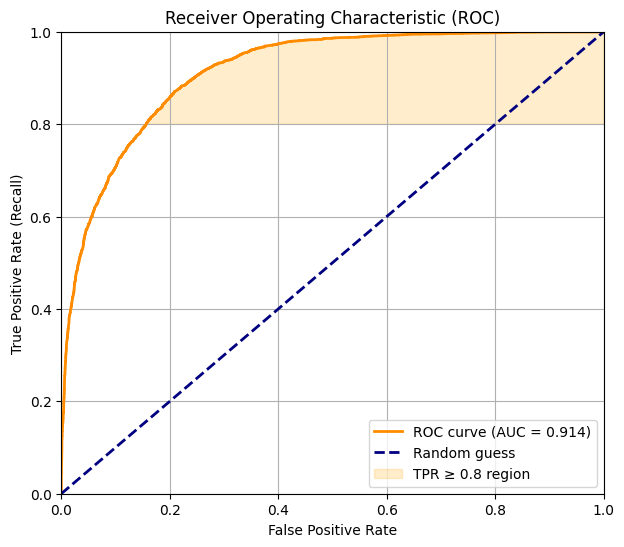

In [280]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
best_model = grid_auc.best_estimator_

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
predictions = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
predictions = pd.DataFrame(predictions)
print(score(y,predictions,"your mom"))

fpr, tpr, thresholds = roc_curve(y, predictions)
roc_auc = roc_auc_score(y, predictions)


plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

# Highlight the partial AUC region (TPR ≥ 0.8)
plt.fill_betweenx(tpr, fpr, 1, where=(tpr >= 0.8), color='orange', alpha=0.2, label='TPR ≥ 0.8 region')

# Style
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [2]:
better_dataset

NameError: name 'better_dataset' is not defined